## Import Data and library

These are the tasks you are asked to do:
1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,precision_recall_curve,auc
from sklearn.cluster import KMeans
from sklearn import preprocessing
import pandasql as ps
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.ensemble import IsolationForest

%matplotlib inline

In [2]:
#load data
fraud = pd.read_csv("Fraud_Data.csv")
ip = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [18]:
df = pd.read_csv("Combined_data.csv")

In [19]:
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [33]:
df=df.rename(columns={'Unnamed: 0':'id'})

## Exploratory Data Analysis

First, we need to find the country for each user

In [9]:
country = df[['user_id','country']]

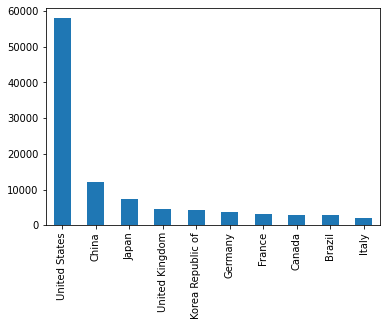

In [11]:
country.country.value_counts()[:10].plot(kind = "bar")

In [35]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [101]:
#if the difference between signup and purchase time is too small, it might be fraud
timediff= df['purchase_time']-df['signup_time']
timediff= timediff.apply(lambda x: x.seconds)
df['timediff'] = timediff
df.head()

,id,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timediff
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,60085
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


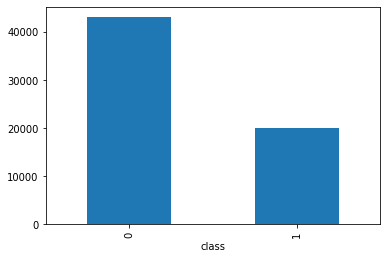

In [104]:
df.groupby('class')['timediff'].mean().plot(kind = 'bar')


In [110]:
#check the user id for unique device
#it's suspicious for different users using the same device
device = df[['user_id','device_id']].groupby('device_id').count().reset_index()
device = device.rename(columns = {'user_id':'user_count'})
device.head()

,device_id,user_count
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1


In [112]:
#put it back to the data
df = df.merge(device, on='device_id')

In [114]:
#check user id for unique ip address
#for those ip address with different user id, it might be suspicious
ip = df[['user_id','ip_address']].groupby("ip_address").count().reset_index()
ip = ip.rename(columns={'user_id':'user_count_for_ip'})
ip.head()

,ip_address,user_count_for_ip
0,52093.496895,1
1,93447.138961,1
2,105818.501505,1
3,117566.664867,1
4,131423.789042,1


In [115]:
df = df.merge(ip, on='ip_address')

In [120]:
#check for frequency,lower frequency id tend to be suspicious
freq = df[['user_id','id']].groupby('user_id').count().reset_index()
freq=freq.rename(columns={'id':'frequency'})

In [121]:
df = df.merge(freq, on='user_id')

In [131]:
#check for year and month for each date time
df['signup_year'] = df['signup_time'].dt.strftime('%Y')
df['signup_month'] = df['signup_time'].dt.strftime('%m')


In [132]:
df.head()

,id,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timediff,user_count,user_count_for_ip,frequency,country_missing,signup_year,signup_month
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,0,2015,02
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,1,0,2015,06
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0,2015,01
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0,2015,01
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0,2015,01


In [50]:
#since missing country might means the ip address is wrong which is suspicious, we cannot remove those country, instead, fill with string missing

df_sub = df_sub.fillna('missing')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 2 to 400000
Data columns (total 11 columns):
signup_time       151112 non-null int64
purchase_time     151112 non-null int64
frequency         151112 non-null int64
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
country           151112 non-null object
class             151112 non-null int64
dtypes: int64(6), object(5)
memory usage: 13.8+ MB


In [124]:
df['country_missing'] = np.where(df['country']=='missing',1,0)

In [125]:
df.head()

,id,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timediff,user_count,user_count_for_ip,frequency,country_missing
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,0
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,1,0
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0
3,2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0
4,22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,1,0


## Modeling

model to predict fraud

In [68]:
df1 = df_sub
df1.head()
df1['device_id'] = df1['device_id'].astype('category')
df1['source'] = df1['source'].astype('category')
df1['browser'] = df1['browser'].astype('category')
df1['sex'] = df1['sex'].astype('category')
df1['country'] = df1['country'].astype('category')
df1['fraud'] = df1['class'].astype('category')

In [69]:
df1.head()

,signup_time,purchase_time,frequency,purchase_value,device_id,source,browser,sex,age,country,class,fraud
user_id,,,,,,,,,,,,
2,219,297,1,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,United States,0,0
4,76,80,1,41,MKFUIVOHLJBYN,Direct,Safari,F,38,Switzerland,0,0
8,81,124,1,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,United States,0,0
9,93,209,1,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,missing,0,0
12,219,286,1,35,MSNWCFEHKTIOY,Ads,Safari,M,19,Mexico,0,0


In [78]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 2 to 400000
Data columns (total 12 columns):
signup_time       151112 non-null int64
purchase_time     151112 non-null int64
frequency         151112 non-null int64
purchase_value    151112 non-null int64
device_id         151112 non-null category
source            151112 non-null category
browser           151112 non-null category
sex               151112 non-null category
age               151112 non-null int64
country           151112 non-null category
class             151112 non-null int64
fraud             151112 non-null category
dtypes: category(6), int64(6)
memory usage: 15.6 MB


In [70]:
#split dataset
X = df1[['signup_time',
 'purchase_time',
 'frequency',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'country']]
y = df1['fraud']
X_train,X_test, y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.3)

In [72]:
print(df1['fraud'].value_counts()) #imbalanced

0    136961
1     14151
Name: fraud, dtype: int64


In [83]:
X_train_num = pd.DataFrame(X_train[['signup_time',
 'purchase_time',
 'purchase_value',
 'age']])

In [84]:
X_train_num.head()

,signup_time,purchase_time,purchase_value,age
user_id,,,,
244176,81,143,28,34
33176,59,133,14,26
153460,168,209,30,22
337910,198,211,19,41
379438,210,292,52,42


Isolation forest

In [126]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "16.0.2" 2021-07-20; OpenJDK Runtime Environment Temurin-16.0.2+7 (build 16.0.2+7); OpenJDK 64-Bit Server VM Temurin-16.0.2+7 (build 16.0.2+7, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rb/y6g6f4j50ml8sf3x1w3f85ym0000gn/T/tmp3lhqrujr
  JVM stdout: /var/folders/rb/y6g6f4j50ml8sf3x1w3f85ym0000gn/T/tmp3lhqrujr/h2o_jingrugong_started_from_python.out
  JVM stderr: /var/folders/rb/y6g6f4j50ml8sf3x1w3f85ym0000gn/T/tmp3lhqrujr/h2o_jingrugong_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_jingrugong_fhs7ny
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [133]:
df1 = H2OFrame(df)
df1.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


id,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timediff,user_count,user_count_for_ip,frequency,country_missing,signup_year,signup_month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.32758e+08,0,Japan,13882,1,1,1,0,2015,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.50311e+08,0,United States,17944,1,1,1,0,2015,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
2626,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
22106,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
32909,260959,2015-01-01 18:52:39,2015-01-01 18:52:40,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
47972,101604,2015-01-01 18:52:43,2015-01-01 18:52:44,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
49082,7626,2015-01-01 18:52:36,2015-01-01 18:52:37,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
50332,135063,2015-01-01 18:52:35,2015-01-01 18:52:36,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,1,United States,1,12,12,1,0,2015,1
76807,273863,2015-01-01 18:52:33,2015-01-31 07:47:31,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.62147e+09,0,United States,46498,12,12,1,0,2015,1


In [134]:
df.columns

Index(['id', 'user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'timediff', 'user_count', 'user_count_for_ip', 'frequency',
       'country_missing', 'signup_year', 'signup_month'],
      dtype='object')

In [135]:

df1['source'] = df1['source'].asfactor()
df1['browser'] = df1['browser'].asfactor()
df1['sex'] = df1['sex'].asfactor()
df1['country'] = df1['country'].asfactor()
df1['fraud'] = df1['class'].asfactor()

choose features for model

In [136]:
split = df1['fraud'].stratified_split(test_frac = 0.25, seed = 42)
train = df1[split=='train']
test = df1[split=='train']
features = ['purchase_value','source', 'browser', 'sex', 'age',
       'country', 'timediff', 'user_count', 'user_count_for_ip', 'frequency',
       'country_missing', 'signup_year', 'signup_month']
target = 'fraud'

In [138]:
#build random forest model
#balance the target by upsampling
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True,model_id ="RF_balanced")
model.train(x=features, y= target, training_frame = train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  RF_balanced


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,7082387.0,20.0,20.0,20.0,2649.0,5658.0,4376.39




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11718764090375766
RMSE: 0.34232680424377765
LogLoss: 0.33414320041326895
Mean Per-Class Error: 0.0311609656329946
AUC: 0.9948063476020883
AUCPR: 0.9946201575604448
Gini: 0.9896126952041766

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.051312838365526026: 


,,0,1,Error,Rate
0,0,97054.0,5667.0,0.0552,(5667.0/102721.0)
1,1,735.0,102018.0,0.0072,(735.0/102753.0)
2,Total,97789.0,107685.0,0.0312,(6402.0/205474.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.051313,0.969578,338.0
1,max f2,0.044320,0.985439,342.0
2,max f0point5,0.084381,0.959181,318.0
3,max accuracy,0.051313,0.968843,338.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.029740,1.000000,353.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.051313,0.938767,338.0
8,max min_per_class_accuracy,0.074855,0.958859,324.0
9,max mean_per_class_accuracy,0.051313,0.968839,338.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 35.55 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.190034,1.000000,1.999689,1.999689,1.000000,1.000000,1.000000,1.000000,0.380008,0.380008,99.968857,99.968857,0.380008
1,2,0.201510,0.998060,1.999689,1.999689,1.000000,0.998160,1.000000,0.999895,0.022948,0.402957,99.968857,99.968857,0.402957
2,3,0.299999,0.626763,1.999689,1.999689,1.000000,0.926267,1.000000,0.975723,0.196948,0.599905,99.968857,99.968857,0.599905
3,4,0.400002,0.239145,1.981685,1.995188,0.990997,0.398238,0.997749,0.831348,0.198174,0.798079,98.168476,99.518751,0.796278
4,5,0.500000,0.074622,1.607965,1.917744,0.804108,0.139237,0.959022,0.692929,0.160793,0.958872,60.796489,91.774449,0.917887
5,6,0.599998,0.025448,0.411286,1.666672,0.205675,0.039895,0.833466,0.584092,0.041128,1.000000,-58.871446,66.667207,0.800129
6,7,0.700001,0.017992,0.000000,1.428569,0.000000,0.021363,0.714396,0.503700,0.000000,1.000000,-100.000000,42.856944,0.600092
7,8,0.799999,0.012651,0.000000,1.250002,0.000000,0.015255,0.625098,0.442645,0.000000,1.000000,-100.000000,25.000152,0.400064
8,9,0.899997,0.007386,0.000000,1.111115,0.000000,0.010054,0.555644,0.394580,0.000000,1.000000,-100.000000,11.111472,0.200037
9,10,1.000000,0.000000,0.000000,1.000000,0.000000,0.004003,0.500078,0.355521,0.000000,1.000000,-100.000000,0.000000,0.000000




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-04-19 16:32:44,0.057 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-04-19 16:32:44,0.502 sec,1.0,0.309466,0.777050,0.964114,0.948022,1.922949,0.091295
2,,2022-04-19 16:32:44,0.691 sec,2.0,0.323730,0.673175,0.964777,0.952908,1.939618,0.091452
3,,2022-04-19 16:32:45,0.956 sec,3.0,0.329859,0.589544,0.967308,0.958707,1.953534,0.087969
4,,2022-04-19 16:32:45,1.210 sec,4.0,0.326737,0.514477,0.972231,0.965514,1.964188,0.079640
5,,2022-04-19 16:32:45,1.471 sec,5.0,0.329300,0.469565,0.974777,0.969777,1.972269,0.075981
6,,2022-04-19 16:32:45,1.715 sec,6.0,0.333481,0.438461,0.976900,0.973275,1.978860,0.074315
7,,2022-04-19 16:32:46,1.990 sec,7.0,0.331976,0.409297,0.979952,0.977034,1.983276,0.069600
8,,2022-04-19 16:32:46,2.250 sec,8.0,0.331440,0.382288,0.982485,0.980431,1.987914,0.066269
9,,2022-04-19 16:32:46,2.516 sec,9.0,0.330505,0.364470,0.984749,0.983166,1.990730,0.063354



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,user_count,1.099940e+06,1.000000,0.356654
1,timediff,6.760222e+05,0.614599,0.219199
2,user_count_for_ip,3.386939e+05,0.307920,0.109821
3,signup_month,2.818733e+05,0.256262,0.091397
4,country,2.445642e+05,0.222343,0.079300
5,purchase_value,1.626208e+05,0.147845,0.052730
6,age,1.550818e+05,0.140991,0.050285
7,browser,6.319000e+04,0.057449,0.020489
8,source,3.907322e+04,0.035523,0.012669
9,sex,2.299111e+04,0.020902,0.007455


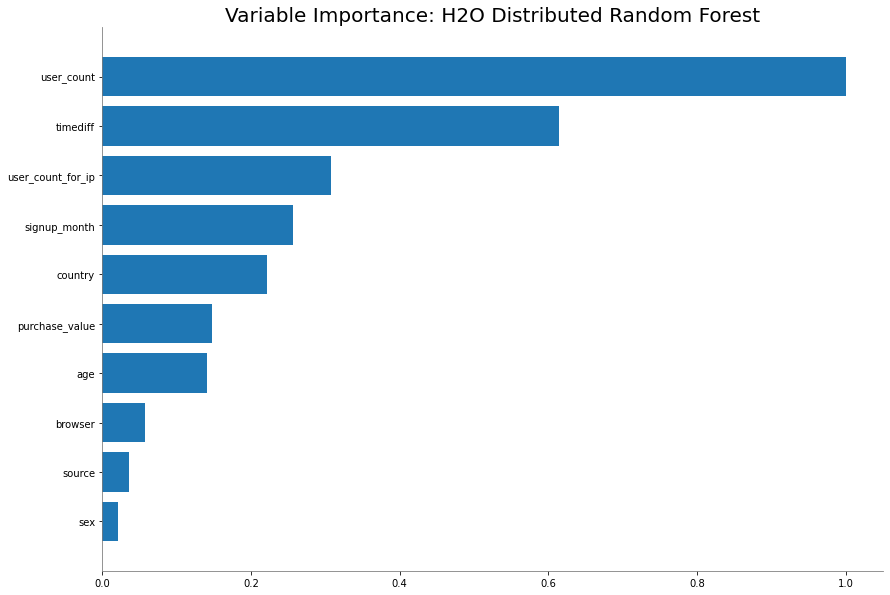

<Figure size 432x288 with 0 Axes>

In [139]:
model.varimp_plot()

make prediction

In [140]:
train_true = train.as_data_frame()['fraud'].values
test_true = test.as_data_frame()['fraud'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [142]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.3).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    102721
           1       1.00      0.76      0.86     10613

    accuracy                           0.98    113334
   macro avg       0.99      0.88      0.92    113334
weighted avg       0.98      0.98      0.98    113334



In [65]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8a8d closed.


## Results 

the cost for false negative is high for fraud detection, so we use recall instead of precision